In [214]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import colormaps 
import seaborn as sns
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from collections import Counter
import copy

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
s2ag_papers = 'subugoe-wag-closed.S2AG.papers'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

## Abdeckung von DOIs

In [5]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_dois, 
                              COUNT(DISTINCT(corpusid)) AS number_of_publications, 
                              EXTRACT (YEAR FROM publicationdate) AS year
                       FROM {s2ag_papers} 
                       GROUP BY year
                       ORDER BY year DESC
                       """).to_dataframe()

In [6]:
df_doi_2000 = df_doi[df_doi.year > 2000]

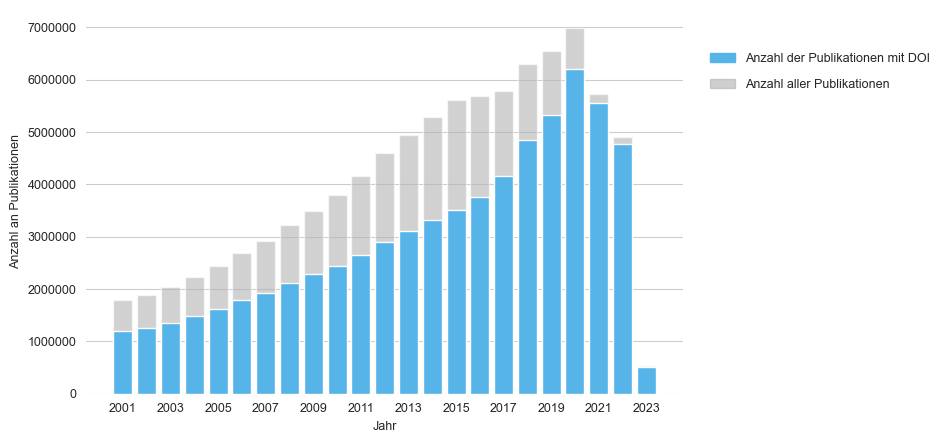

In [7]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_dois', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            errorbar=None)

plt.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

doi_patch = mpatches.Patch(color='#56B4E9', label='Anzahl der Publikationen mit DOI')
not_doi_patch = mpatches.Patch(color='#b3b3b3a0', label='Anzahl aller Publikationen')

lgd = fig.legend(handles=[doi_patch, not_doi_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()

## Abdeckung von Publikationstypen

In [8]:
df_types_single = client.query(f"""
                                SELECT type, COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                     SELECT type, corpusid
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                     )
                                GROUP BY type
                                """).to_dataframe()

In [9]:
df_types_single

,type,number_of_publications
0,Study,2341438
1,JournalArticle,39583455
2,Editorial,656743
3,Review,14607813
4,Conference,3845648
5,News,238177
6,LettersAndComments,1539429
7,ClinicalTrial,582157
8,Dataset,727
9,MetaAnalysis,103671


In [10]:
df_types_agg = client.query(f"""
                             SELECT ARRAY_TO_STRING(publicationtypes, ",") AS types, 
                                    COUNT(DISTINCT(corpusid)) AS number_of_publications
                             FROM {s2ag_papers}
                             GROUP BY types
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [11]:
df_types_agg

,types,number_of_publications
0,,157488277
1,JournalArticle,28452480
2,Review,8790961
3,"Review,JournalArticle",2645627
4,Conference,2254022
...,...,...
615,"Editorial,News,JournalArticle",1
616,"Editorial,JournalArticle,Conference,Review",1
617,"LettersAndComments,CaseReport,JournalArticle,E...",1
618,"LettersAndComments,Study,MetaAnalysis,JournalA...",1


In [12]:
df_types_agg['types'] = df_types_agg['types'].apply(lambda x: x.split(','))

In [13]:
types_dict_count = Counter(
    Dataset=0,
    MetaAnalysis=0,
    Book=0,
    News=0,
    Conference=0,
    LettersAndComments=0,
    ClinicalTrial=0,
    Editorial=0,
    JournalArticle=0,
    Study=0,
    CaseReport=0,
    Review=0
)

In [14]:
types_dict = dict(
    Dataset=copy.copy(types_dict_count),
    MetaAnalysis=copy.copy(types_dict_count),
    Book=copy.copy(types_dict_count),
    News=copy.copy(types_dict_count),
    Conference=copy.copy(types_dict_count),
    LettersAndComments=copy.copy(types_dict_count),
    ClinicalTrial=copy.copy(types_dict_count),
    Editorial=copy.copy(types_dict_count),
    JournalArticle=copy.copy(types_dict_count),
    Study=copy.copy(types_dict_count),
    CaseReport=copy.copy(types_dict_count),
    Review=copy.copy(types_dict_count)
    
)

In [15]:
def count_combinations(type_combination: list, number_of_publications: int):
    for t in type_combination:
        if t == '':
            continue
        d = types_dict[t]
        for t_count in d:
            for t2 in type_combination:
                if t2 == t_count:
                    d[t_count] += number_of_publications

In [16]:
for row in df_types_agg.to_dict('records'):
    count_combinations(row['types'], row['number_of_publications'])

In [17]:
types_dict['Dataset '] = types_dict.pop('Dataset')
types_dict['MetaAnalysis '] = types_dict.pop('MetaAnalysis')
types_dict['Book '] = types_dict.pop('Book')
types_dict['News '] = types_dict.pop('News')
types_dict['Conference '] = types_dict.pop('Conference')
types_dict['LettersAndComments '] = types_dict.pop('LettersAndComments')
types_dict['ClinicalTrial '] = types_dict.pop('ClinicalTrial')
types_dict['Editorial '] = types_dict.pop('Editorial')
types_dict['JournalArticle '] = types_dict.pop('JournalArticle')
types_dict['Study '] = types_dict.pop('Study')
types_dict['CaseReport '] = types_dict.pop('CaseReport')
types_dict['Review '] = types_dict.pop('Review')

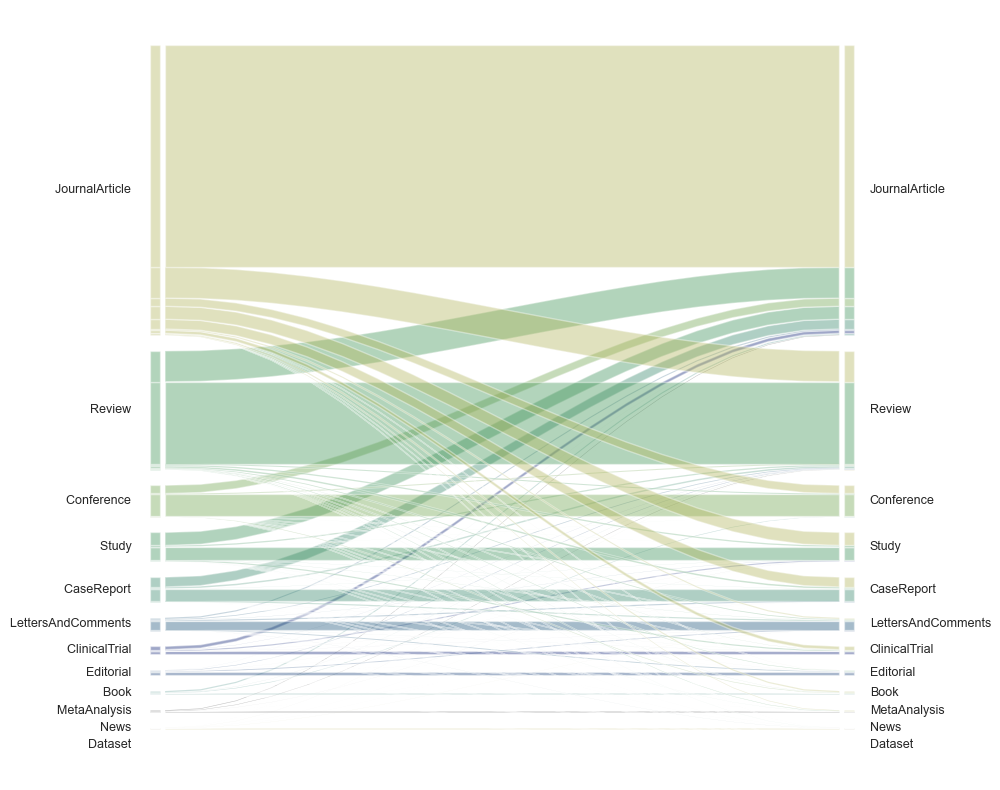

In [18]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(types_dict, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(10,10)
plt.show()

## Open Access nach Publikationstyp

In [19]:
df_types_oa = client.query(f"""
                            SELECT type, isopenaccess, year, COUNT(DISTINCT(corpusid)) AS number_of_publications
                            FROM (
                                SELECT type, corpusid, isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                                FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                WHERE year >= 2010
                                 )
                            GROUP BY type, isopenaccess, year
                            """).to_dataframe()

In [20]:
df_types_oa = pd.merge(df_types_oa, 
                       df_types_oa.groupby(['type', 'year'])['number_of_publications'].sum().to_frame()\
                           .reset_index()\
                           .rename(columns={'number_of_publications':'number_of_total_publications'}),
                       on=['type', 'year'])

In [21]:
df_types_oa['proportion'] = df_types_oa['number_of_publications']/df_types_oa['number_of_total_publications']

In [22]:
df_types_oa

,type,isopenaccess,year,number_of_publications,number_of_total_publications,proportion
0,Review,False,2010,212907,292755,0.727253
1,Review,True,2010,79848,292755,0.272747
2,JournalArticle,False,2013,630579,1068931,0.589916
3,JournalArticle,True,2013,438352,1068931,0.410084
4,Review,False,2020,442146,697874,0.633561
...,...,...,...,...,...,...
312,News,True,2017,1505,3983,0.377856
313,News,False,2017,2478,3983,0.622144
314,Conference,True,2013,14992,134716,0.111286
315,Conference,False,2013,119724,134716,0.888714


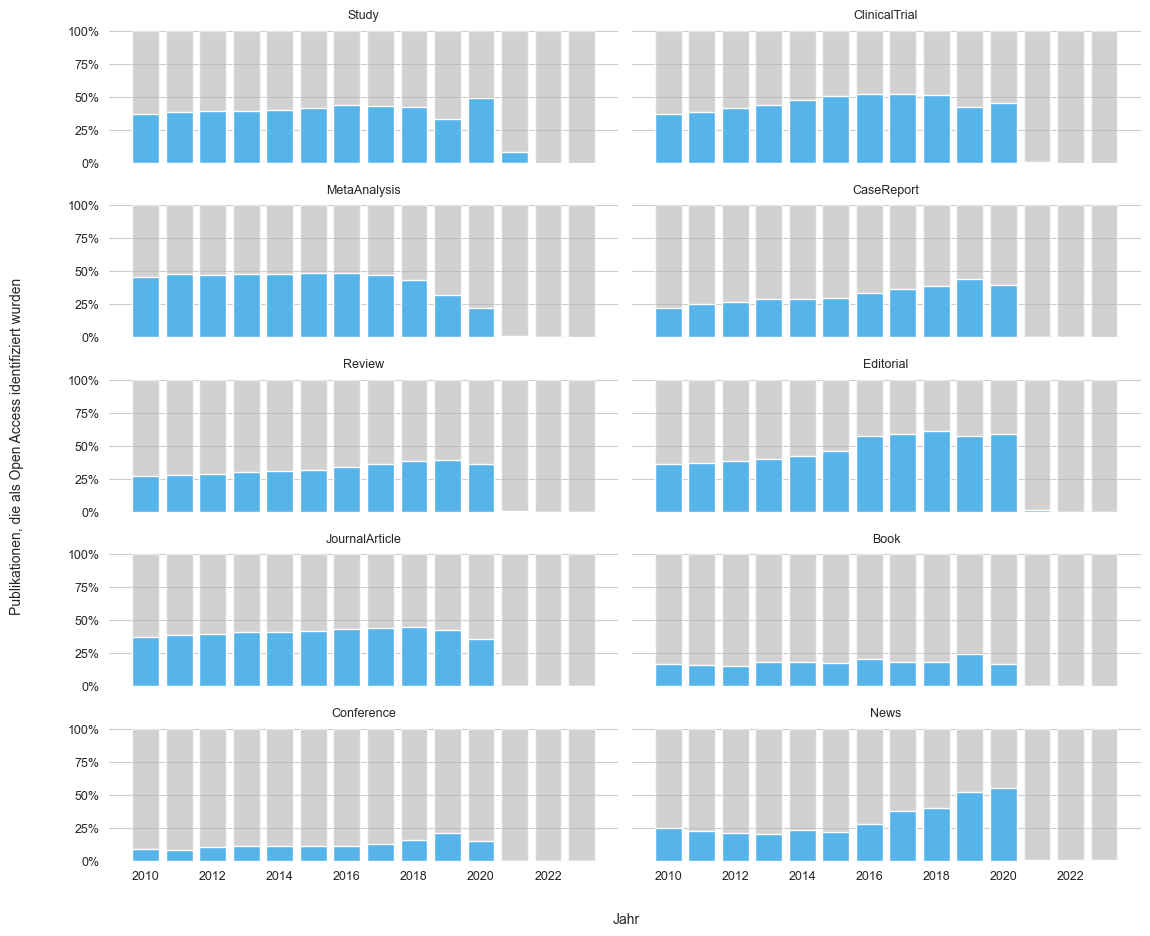

In [23]:
fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(11, 9))

axes = axes.reshape(-1)

type_list = list(set(df_types_oa['type']))
type_list.remove('Dataset')
type_list.remove('LettersAndComments')

for i, ax in enumerate(axes, 1):
    pub_type = type_list[i-1]
    
    df2 = df_types_oa[df_types_oa['type'] == pub_type]
    
    sns.barplot(data=df2, 
                x='year', 
                y=[1] * len(df2),
                alpha=0.6,
                color='#b3b3b3a0',
                saturation=1,
                errorbar=None,
                ax=ax)
    
    sns.barplot(data=df2[df2.isopenaccess==True], 
                x='year', 
                y='proportion', 
                alpha=1,
                color='#56B4E9',
                saturation=1,
                errorbar=None,
                ax=ax)
    
    sns.despine(bottom = True, left = True)
    
    plt.locator_params(nbins=8, axis='x')
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(pub_type, fontdict={'fontsize': 9}, pad=4)
    
x_label = fig.text(0.52, -0.03, 'Jahr', ha='center', 
                   fontdict={'fontsize': 10})

y_label = fig.text(-0.04, 0.5, 'Publikationen, die als Open Access identifiziert wurden', va='center', 
                   rotation='vertical', fontdict={'fontsize': 10})

plt.tight_layout()

plt.show()

## Publikationstyp nach Verlag

In [131]:
df_venue = client.query(f"""
                         SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_total_publications
                         FROM {s2ag_papers}
                         GROUP BY venue
                         ORDER BY number_of_total_publications DESC
                         LIMIT 20
                         """).to_dataframe()

In [132]:
df_venue

,venue,number_of_total_publications
0,,144717004
1,Nature,421802
2,PLoS ONE,274163
3,Science,273596
4,Scientific Reports,220588
5,SSRN Electronic Journal,217401
6,ArXiv,215815
7,Journal of Biological Chemistry,190552
8,The Lancet,178665
9,bioRxiv,164477


In [330]:
df_venue_type = client.query(f"""
                              SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_publications, type
                              FROM (
                                 SELECT type, venue, corpusid
                                 FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                              )
                              GROUP BY venue, type
                              ORDER BY number_of_publications DESC
                              """).to_dataframe()

In [350]:
df_venue_type_sum = df_venue_type.groupby(['venue'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False).head(20)
df_venue_type_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)

In [351]:
#df_venue_type_merged = pd.merge(df_venue, df_venue_type, on=['venue'])
df_venue_type_merged = pd.merge(df_venue_type_sum, df_venue_type, on=['venue'])

In [352]:
df_venue_type_merged['proportion'] = (df_venue_type_merged['number_of_publications'])/\
                                        (df_venue_type_merged['number_of_total_publications']) * 100

df_venue_type_merged['proportion'] = df_venue_type_merged['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [353]:
df_venue_type_merged

,venue,number_of_total_publications,number_of_publications,type,proportion
0,,8366837,7332570,Review,87.64
1,,8366837,957882,JournalArticle,11.45
2,,8366837,32098,Editorial,0.38
3,,8366837,26876,Book,0.32
4,,8366837,9221,LettersAndComments,0.11
...,...,...,...,...,...
161,International Journal of Environmental Researc...,75213,376,Editorial,0.50
162,International Journal of Environmental Researc...,75213,374,CaseReport,0.50
163,International Journal of Environmental Researc...,75213,159,MetaAnalysis,0.21
164,International Journal of Environmental Researc...,75213,74,ClinicalTrial,0.10


In [354]:
df_venue_type_merged.venue.replace('', 'Venue unknown', inplace=True)
df_venue_type_merged.type.replace('', 'Type unknown', inplace=True)

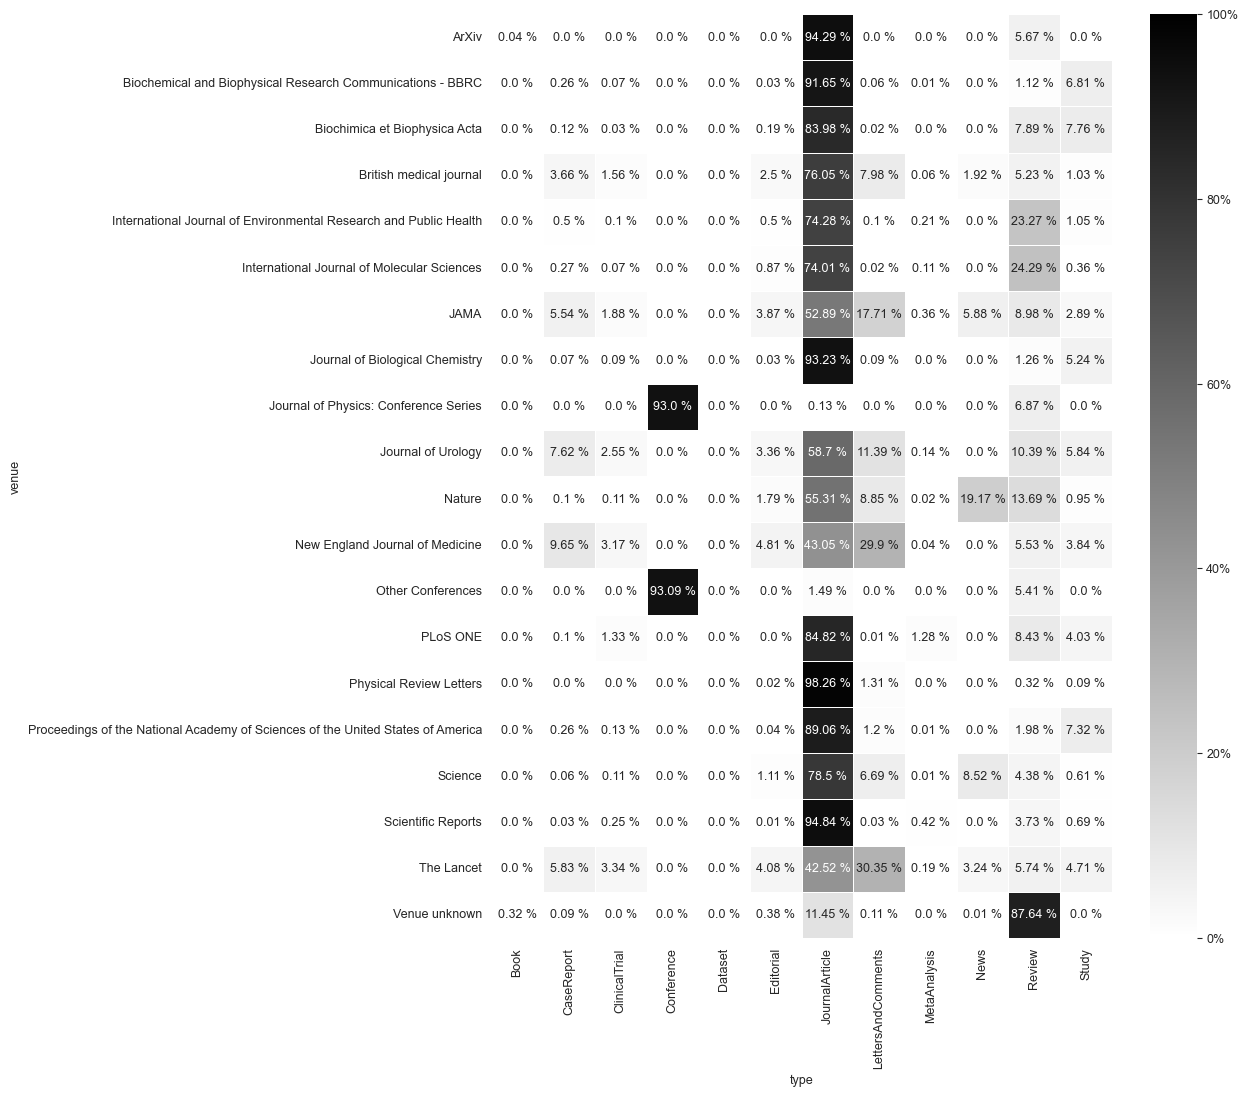

In [355]:
df_heatmap = pd.pivot_table(df_venue_type_merged, 
                            index='venue', 
                            columns='type', 
                            values='proportion', 
                            fill_value=float(0))

fig, ax = plt.subplots(figsize=(10, 12))
ax1 = sns.heatmap(df_heatmap, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()